## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import geopandas as gpd
import pandas as pd
import pyproj
import rioxarray
import matplotlib
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

In [8]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

def assign_proj(data, proj_data):
    
    data = data.rio.write_crs(proj_data.rio.crs)
    data = data.rio.set_spatial_dims(x_dim='west_east', y_dim='south_north')
    
    return data

## 1. Open Data

In [4]:
general_path = 'data'
urban_boundary = gpd.read_file(fr'{general_path}/lu_index/urban_boundaries.shp')

### 1.1 Extra Datasets

In [12]:
proj_data = xr.open_dataset(r'data/era5_lin_urban_PRCP_wrfout_d03_2017-07-18.nc')['PRCP']
# assign projection and dim info
proj_data = proj_data.rio.write_crs(proj_data.attrs['pyproj_srs'])
proj_data = proj_data.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

### 1.2 ERA5

#### 1.2.1 T2C

In [9]:
run_data = 'era5'
variable = 'T2C'
day_no = '18'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**{day_no}*')

In [10]:
data_path

['data/era5_LIN_nourban_T2C_wrfout_d03_2017-07-18.nc',
 'data/era5_LIN_urban_T2C_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_nourban_T2C_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_urban_T2C_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_nourban_T2C_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_urban_T2C_wrfout_d03_2017-07-18.nc']

In [13]:
# open data
dt_t2c_era5 = xr.open_mfdataset(data_path, combine='nested',
                       concat_dim='ens').isel(time=slice(0,8))[variable]
dt_t2c_era5 = clip_to_city(assign_proj(dt_t2c_era5, proj_data), urban_boundary)

# ensemble member list
ensemble_members = list(dt_t2c_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_t2c_era5_urban_ens = dt_t2c_era5.sel(ens=urban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_t2c_era5_nourban_ens = dt_t2c_era5.sel(ens=nourban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_t2c_era5_diff = dt_t2c_era5_urban_ens - dt_t2c_era5_nourban_ens

In [14]:
dt_t2c_era5_diff

<xarray.DataArray 'T2C' (time: 8)>
dask.array<sub, shape=(8,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
    xtime        (time) datetime64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T07:00:00
    spatial_ref  int64 0

#### 1.2.2 TSK

In [15]:
run_data = 'era5'
variable = 'TSK'
day_no = '18'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**{day_no}*')

In [16]:
data_path

['data/era5_LIN_nourban_TSK_wrfout_d03_2017-07-18.nc',
 'data/era5_LIN_urban_TSK_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_nourban_TSK_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_urban_TSK_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_nourban_TSK_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_urban_TSK_wrfout_d03_2017-07-18.nc']

In [17]:
# open data
dt_h_era5 = xr.open_mfdataset(data_path, combine='nested',
                       concat_dim='ens').isel(time=slice(0,8))[variable] - 273.15 # K to C
dt_h_era5 = clip_to_city(assign_proj(dt_h_era5, proj_data), urban_boundary)

# ensemble member list
ensemble_members = list(dt_h_era5.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_h_era5_urban_ens = dt_h_era5.sel(ens=urban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_h_era5_nourban_ens = dt_h_era5.sel(ens=nourban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_h_era5_diff = dt_h_era5_urban_ens - dt_h_era5_nourban_ens

In [18]:
dt_h_era5_diff

<xarray.DataArray 'TSK' (time: 8)>
dask.array<sub, shape=(8,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
    xtime        (time) datetime64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T07:00:00
    spatial_ref  int64 0

### 1.3 GFS

#### 1.3.1 T2C

In [19]:
run_data = 'gfs'
variable = 'T2C'
day_no='18'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**{day_no}*')

In [20]:
data_path

['data/gfs_LIN_nourban_T2C_wrfout_d03_2017-07-18.nc',
 'data/gfs_LIN_urban_T2C_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_nourban_T2C_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_urban_T2C_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_nourban_T2C_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_urban_T2C_wrfout_d03_2017-07-18.nc']

In [21]:
# open data
dt_t2c_gfs = xr.open_mfdataset(data_path, combine='nested',
                       concat_dim='ens').isel(time=slice(0,8))[variable]
dt_t2c_gfs = clip_to_city(assign_proj(dt_t2c_gfs, proj_data), urban_boundary)

# ensemble member list
ensemble_members = list(dt_t2c_gfs.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_t2c_gfs_urban_ens = dt_t2c_gfs.sel(ens=urban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_t2c_gfs_nourban_ens = dt_t2c_gfs.sel(ens=nourban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_t2c_gfs_diff = dt_t2c_gfs_urban_ens - dt_t2c_gfs_nourban_ens

In [22]:
dt_t2c_gfs_diff

<xarray.DataArray 'T2C' (time: 8)>
dask.array<sub, shape=(8,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
    xtime        (time) datetime64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T07:00:00
    spatial_ref  int64 0

#### 1.3.2 TSK

In [23]:
run_data = 'gfs'
variable = 'TSK'
day_no = '18'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}**{day_no}*')

In [24]:
data_path

['data/gfs_LIN_nourban_TSK_wrfout_d03_2017-07-18.nc',
 'data/gfs_LIN_urban_TSK_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_nourban_TSK_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_urban_TSK_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_nourban_TSK_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_urban_TSK_wrfout_d03_2017-07-18.nc']

In [27]:
# open data
dt_h_gfs = xr.open_mfdataset(data_path, combine='nested',
                       concat_dim='ens').isel(time=slice(0,8))[variable] - 273.15 # K to C
dt_h_gfs = clip_to_city(assign_proj(dt_h_gfs, proj_data), urban_boundary)

# ensemble member list
ensemble_members = list(dt_h_gfs.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

dt_h_gfs_urban_ens = dt_h_gfs.sel(ens=urban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_h_gfs_nourban_ens = dt_h_gfs.sel(ens=nourban_members).mean(dim='ens').mean(dim=['south_north', 'west_east'])
dt_h_gfs_diff = dt_h_gfs_urban_ens - dt_h_gfs_nourban_ens

In [28]:
dt_h_gfs_diff

<xarray.DataArray 'TSK' (time: 8)>
dask.array<sub, shape=(8,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
    xtime        (time) datetime64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18 ... 2017-07-18T07:00:00
    spatial_ref  int64 0

## 2. Visualization

### 2.1 Quick Look

#### 2.1.1 Original Data

Text(0.5, 1.0, '2m Temperature')

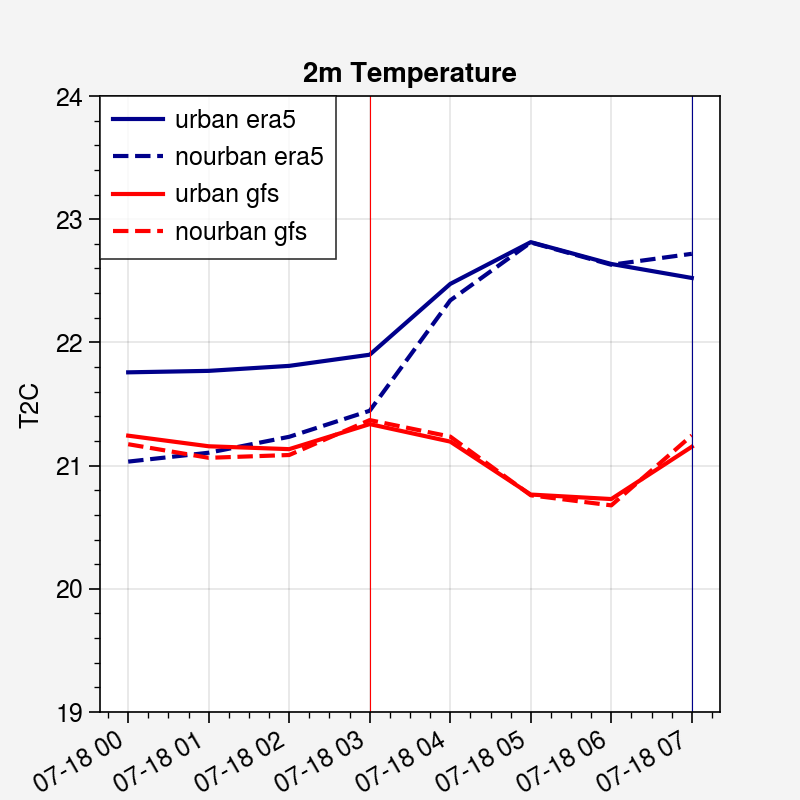

In [63]:
dt_t2c_era5_urban_ens.plot(label='urban era5', color='darkblue')
dt_t2c_era5_nourban_ens.plot(label='nourban era5', color='darkblue', linestyle='--')

dt_t2c_gfs_urban_ens.plot(label='urban gfs', color='red')
dt_t2c_gfs_nourban_ens.plot(label='nourban gfs', color='red', linestyle='--')

plt.legend()

# vertical lines
plt.axvline(x=dt_t2c_era5_nourban_ens['time'][7].values, color='darkblue', linewidth=0.4)
plt.axvline(x=dt_t2c_gfs_nourban_ens['time'][3].values, color='red', linewidth=0.4)
plt.ylim(19,24)
plt.title('2m Temperature', weight='bold')

Text(0.5, 1.0, 'Skin Temperature')

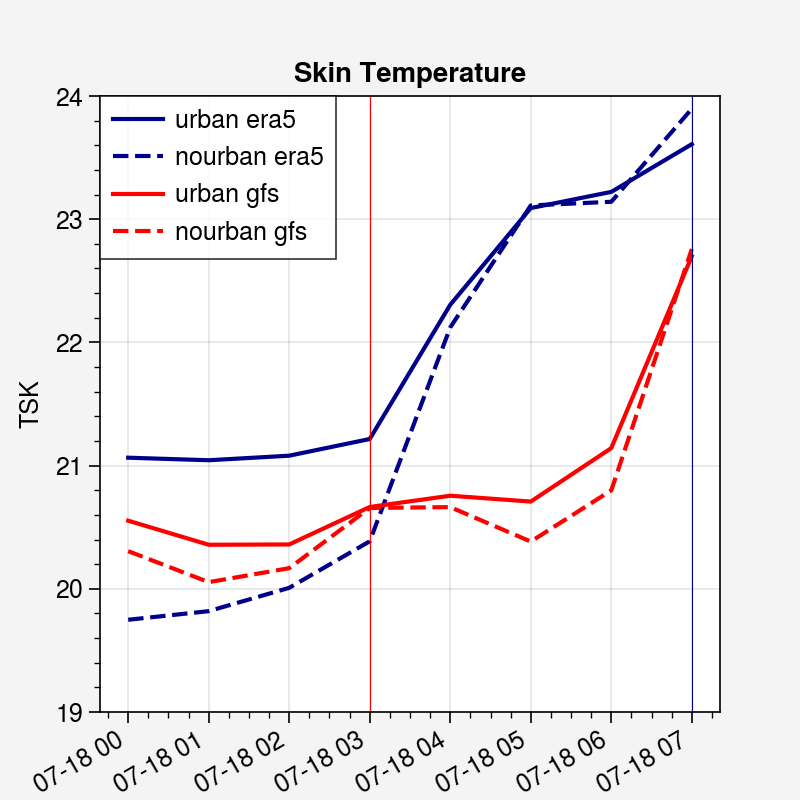

In [64]:
dt_h_era5_urban_ens.plot(label='urban era5', color='darkblue')
dt_h_era5_nourban_ens.plot(label='nourban era5', color='darkblue', linestyle='--')

dt_h_gfs_urban_ens.plot(label='urban gfs', color='red')
dt_h_gfs_nourban_ens.plot(label='nourban gfs', color='red', linestyle='--')

plt.legend()

# vertical lines
plt.axvline(x=dt_h_era5_nourban_ens['time'][7].values, color='darkblue', linewidth=0.4)
plt.axvline(x=dt_h_gfs_nourban_ens['time'][3].values, color='red', linewidth=0.4)
plt.ylim(19,24)
plt.title('Skin Temperature', weight='bold')